In [1]:
import os
# Prevent kernel from dying
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import string, time, math, random, sys, io

# Importing Tensorflow and Keras

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence

# Loading the Raw Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Reads the data
labeledPfd = pd.read_csv("/content/drive/MyDrive/LabeledPoetryFoundationPoems.csv")
labeledPfd = labeledPfd.sample(frac=1) # randomizes the data

# Filters the poems by category
def get_poems_by_category(category):
    data = []
    for poem, emotion in zip(labeledPfd["poem"], labeledPfd["emotion"]):
        if emotion == category:
            data.append(poem)
    return data


# Gets the poems in each category
poems = {
    "joy": get_poems_by_category("joy"),
    "trust": get_poems_by_category("trust"),
    "sadness": get_poems_by_category("sadness"),
    "anticipation": get_poems_by_category("anticipation"),
    "fear": get_poems_by_category("fear"),
    "anger": get_poems_by_category("anger"),
    "disgust": get_poems_by_category("disgust"),
    "surprise": get_poems_by_category("surprise")
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Processing the Data

In this cell, the data is processed into tokens that can be inputted into the model. Here we also create the input-output pair batches that will be used to train, validate, and evaluate, the model.

In [4]:
class Vocabulary:
    def __init__(self):
        punctuation = " .,<>'();?!:-\"\n\t"
        digits = "0123456789"
        self.valid_chars = string.ascii_letters + punctuation + digits

        # Encodes the position of each character in the vocabulary
        self.char2idx = {word: i for i, word in enumerate(self.valid_chars)}
        self.idx2char = np.array(list(self.valid_chars))

    def __len__(self):
        return len(self.valid_chars)

    def chars(self):
        return self.valid_chars
    
    def isValidChar(self, char):
        return char in self.valid_chars
    
    def charToId(self, char):
        return self.char2idx[char]

    def idToChar(self, id):
        return self.idx2char[id]

# Forms the vocabulary shared accross all models
vocab = Vocabulary()


class DataProcessor:
    def __init__(self, dataset, batch_size=32, seq_len=48):
        self.seq_len = seq_len
        full_data = list(dataset)

        # Splits the data into training and testing sets
        tenPercent = math.ceil(len(full_data) * 0.1)
        self.test_set = full_data[:tenPercent]
        full_data = full_data[tenPercent:]

        # Cleans the data by removing
        # punctuation from the dataset
        self.clean_data = self.data_cleaner(full_data)
        print("Number of characters:", len(self.clean_data))
        print("Vocabulary Size: " + str(len(vocab)))

        # Transforms the entire text into integers
        text_as_int = np.array([vocab.charToId(c) for c in self.clean_data])

        # Create training examples / targets
        char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
        sequences = char_dataset.batch(self.seq_len+1, drop_remainder=True)

        self.dataset = sequences.map(self.split_input_target)

        print("\nExample Input-Target pair:")
        for input_example, target_example in self.dataset.take(1):
            print('Input data: ', repr(''.join(vocab.idToChar(input_example.numpy()))))
            print('Target data:', repr(''.join(vocab.idToChar(target_example.numpy()))))

        # Buffer size to shuffle the dataset
        # (TF data is designed to work with possibly infinite sequences,
        # so it doesn't attempt to shuffle the entire sequence in memory. Instead,
        # it maintains a buffer in which it shuffles elements).
        BUFFER_SIZE = 10000
        self.dataset = self.dataset.shuffle(BUFFER_SIZE).batch(
            batch_size,
            drop_remainder=True
        )
        print("\n")
        print("Number of batches: " + str(len(dataset)))
        print(self.dataset)

        fivePercent = math.ceil(len(dataset) * 0.1)
        self.val_inps = []
        self.val_tars = []
        val = self.dataset.take(fivePercent)
        self.dataset = self.dataset.skip(fivePercent)
        for val_inp, val_tar in val:
            self.val_inps.append(val_inp)
            self.val_tars.append(val_tar)


    def data_cleaner(self, poem_list):
        clean_data = []
        
        for poem in poem_list:
            # Adds the "poem start" symbol
            clean_data.append("<")

            for char in list(poem):
                prevChar = clean_data[len(clean_data) - 1]
                if (vocab.isValidChar(char)):
                    if (char == "\n" and prevChar == "\n"):
                        pass
                    else:
                        clean_data.append(char)

            # Adds the "poem end" symbol
            clean_data.append(">")
        
        return clean_data

    def split_input_target(self, chunk):
        input_text = chunk[:-1]
        target_text = chunk[1:]
        return input_text, target_text

# The Model Base Classes

In the next two blocks we define the `PoemModel` class and the `GeneratorModel` class. With these two classes we are able to reuse the same code for training multiple models and generating poems.

#### The Class for Training the Models

In [5]:
class PoemModel:
    def __init__(self, data, batch_size=32, weights=None, print_summary=False):
        """
        Creates a trainable model.
        ::data - An instance of the `DataProcessor` class.
        ::batch_size - The size of the batches used for training the model. 32
            by default.
        ::weights - When this class is used for prediction, a set of weights
            must be provided from another model which was used for training.
        """

        self.data = data
        self.history = None

        # Global Hyperparameters
        self.recurrent_units = 928
        self.embedding_size = 128
        self.dropout_rate = 0.2
        self.n_epochs = 64
        self.optimizer = keras.optimizers.RMSprop()
        self.loss_function = lambda labels, logits: keras.losses.sparse_categorical_crossentropy(
            labels, logits, from_logits=True
        )

        # Model-Specific Hyperparameters
        self.batch_size = batch_size
        self.weights = weights

        # Creates the model
        self.model = self.__createModel()
        if (print_summary): self.model.summary()


    def train(self):
        """
        Trains the model using the provided data under the GPU
        provided by Google Colab.
        """
        with tf.device('/device:GPU:0'):
            model_callbacks = [
                # Reduces the learning rate if the model is having trouble
                # learning the data. This is applied after two epochs with
                # no improvement to the model's loss.
                tf.keras.callbacks.ReduceLROnPlateau(patience=2),
                # If even after reducing the learning rate the model still does
                # not improve, after 5 epochs of non-improving loss, the model
                # halts the training process.
                tf.keras.callbacks.EarlyStopping(patience=4)
            ]

            self.history = self.model.fit(
                self.data.dataset,
                epochs=self.n_epochs,
                callbacks=model_callbacks,
                validation_data=(self.data.val_inps, self.data.val_tars)
            )


    def plot_loss(self, name):
        if (self.history != None):
            plt.plot(self.history.history['loss'])
            plt.plot(self.history.history['val_loss'])
            plt.title('Metrics for ' + name + ' model')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()
        else:
            print("The model must be trained before the loss can be plotted.")


    def __createModel(self):
        """
        Creates an new sequential model with the specified
        hyperpearameters. If a set of weights (from anothe model)
        were provided, those weights are set for this model.
        """
        model = keras.models.Sequential([
            layers.Embedding(
                len(vocab),
                self.embedding_size,
                batch_input_shape=(self.batch_size, self.data.seq_len),
                name="EMBEDDING_layer"
            ),
            layers.Dense(len(vocab), activation="tanh", name="TANH_layer"),
            layers.GRU(
                self.recurrent_units,
                stateful=True,
                return_sequences=True,
                recurrent_initializer='glorot_uniform',
                name="GRU_layer"
            ),
            layers.Dropout(self.dropout_rate),
            layers.Dense(len(vocab), name="OUTPUT_layer")
        ])
        
        # If no wights were loaded into this model, we create a
        # new model from scratch. Otherwise we set the provided
        # wights into this model.
        if (self.weights == None):
            model.compile(loss=self.loss_function, optimizer=self.optimizer)
        else:
            model.set_weights(self.weights)
        
        # Returns the created model
        return model

#### The Class for Generating New Poems

In [6]:
class GeneratorModel:
    def __init__(self, trainedModel):
        self.trainedModel = trainedModel

        self.model = PoemModel(
            self.trainedModel.data,
            batch_size=1,
            # Copies the trained weights into this model
            weights=trainedModel.model.get_weights()
        )


    def generate(self, start_string, out_len, temperature=0.5):
        """
        Generates a new poem from the specified starting string.
        ::start_string - A seed string used for generating the new poem.
        ::out_len - The size (in characters) of the generated poem.
        ::temperature - The diversity of the generated text. If the number is
            low, the generated setences will look similar to the sentences it has
            seen before. If the number is high, the sentences will be more
            "original" (but may not look as perfect).
        """
        # Converting our start string to numbers (vectorizing)
        input_eval = [vocab.charToId(s) for s in start_string]
        input_eval = tf.expand_dims(input_eval, 0)

        # Empty string to store our results
        text_generated = []

        # Here batch size == 1
        # model.reset_states()
        for i in range(out_len):
            predictions = self.model.model(input_eval)
            # remove the batch dimension
            predictions = tf.squeeze(predictions, 0)

            # using a categorical distribution to predict
            # the character returned by the model
            predictions = predictions / temperature
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

            # Pass the predicted character as the next input to the model
            # along with the previous hidden state
            input_eval = tf.expand_dims([predicted_id], 0)

            predicted_char = vocab.idToChar(predicted_id)

            if predicted_char == ">":
                print("FOUND POEM END!!!")
                break
            else:
                text_generated.append(predicted_char)

        return (start_string + ''.join(text_generated))

# The Model for the "JOY" Category

### Processing the Data for the "JOY" dataset

In [7]:
joyData = DataProcessor(poems["joy"])

Number of characters: 5985646
Vocabulary Size: 78

Example Input-Target pair:
Input data:  '<\nIn our old shipwrecked days there was an hour,'
Target data: '\nIn our old shipwrecked days there was an hour,\n'


Number of batches: 4281
<BatchDataset shapes: ((32, 48), (32, 48)), types: (tf.int64, tf.int64)>


### Defining the model for the "JOY" category

In [8]:
joyModel = PoemModel(joyData, print_summary=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMBEDDING_layer (Embedding)  (32, 48, 128)             9984      
_________________________________________________________________
TANH_layer (Dense)           (32, 48, 78)              10062     
_________________________________________________________________
GRU_layer (GRU)              (32, 48, 928)             2806272   
_________________________________________________________________
dropout (Dropout)            (32, 48, 928)             0         
_________________________________________________________________
OUTPUT_layer (Dense)         (32, 48, 78)              72462     
Total params: 2,898,780
Trainable params: 2,898,780
Non-trainable params: 0
_________________________________________________________________


### Training the model for the "JOY" category

In [9]:
joyModel.train()

Epoch 1/64
3388/3388 [==============================] - 55s 16ms/step - loss: 1.8463 - val_loss: 1.6239
Epoch 2/64
3388/3388 [==============================] - 53s 16ms/step - loss: 1.6605 - val_loss: 1.5641
Epoch 3/64
3388/3388 [==============================] - 54s 16ms/step - loss: 1.6237 - val_loss: 1.5712
Epoch 4/64
3388/3388 [==============================] - 54s 16ms/step - loss: 1.6049 - val_loss: 1.5593
Epoch 5/64
3388/3388 [==============================] - 53s 16ms/step - loss: 1.5943 - val_loss: 1.5501
Epoch 6/64
3388/3388 [==============================] - 53s 16ms/step - loss: 1.5875 - val_loss: 1.5513
Epoch 7/64
3388/3388 [==============================] - 53s 16ms/step - loss: 1.5839 - val_loss: 1.5273
Epoch 8/64
3388/3388 [==============================] - 53s 16ms/step - loss: 1.5818 - val_loss: 1.5172
Epoch 9/64
3388/3388 [==============================] - 53s 16ms/step - loss: 1.5812 - val_loss: 1.5213
Epoch 10/64
3388/3388 [==============================] - 54s 16m

### Visualizing the Loss

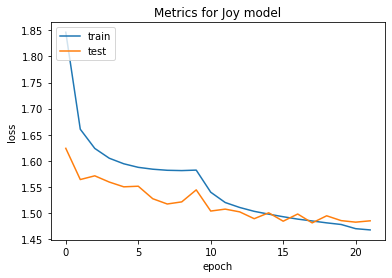

In [10]:
joyModel.plot_loss("Joy")

#### Generating New Poems

In [11]:
# Because we trained the model using batch sizes specified in the
# BATCH_SIZE variable, using the original model will also require
# inputs of BATCH_SIZE in order to make a prediction. Because of that,
# we must create a new model whose batch_size is set to 1, and copy
# the weights from the original model into this prediction model.
joyModelPredictor = GeneratorModel(joyModel)

In [13]:
poem = joyModelPredictor.generate(u"Love is", 200, temperature=0.75)
print(poem)

Love is the soul with ye sipped, Though in the Sunday loth we said nothing. It is a poem
in dusk and then, a little sphere, The great glance of things could not care
To drink of some way to scorn the huge fa
